# Off-line data processing example notebook

## Introduction
This notebook is aimed to present how the user can:
- load the data captured during data acqusition
- perform data processing on GPU using ready-to-use Arrus functions
- define own data processing procedures with GPU processing

In this example the data is loaded from an external file (pickle), the data processing pipeline is defined, data is loaded to the GPU memory, the processing is executed on GPU, and finally the data from selected steps of processing are collected back to the CPU memory for analysis and visualization. This example covers the following data processing routines: RF filtering, down-conversion, beamforming and shear wave detection (for 2-D SWE purposes). Example data comes from the acqusition performed using swe_seq.py example script, which configures the acquisition for a simple 2-D SWE method. 

### Load the required libraries
Code below loads the required Python packages. Some of them are commonly used packages for scientific/numeric computing or data visualization (like NumPy, SciPy or MatplotLib) or p[ackages specific for usage with us4R-lite system - those are included in ARRUS software package.

In [1]:
import scipy.io
import numpy as np
import scipy as sp
import cupy as cp
import matplotlib.pyplot as plt
import os
import time
import argparse
from SWE_utils_cupy_pipelined2 import *
from scipy.signal import firwin, butter, buttord, freqz

from arrus.ops.us4r import *
from arrus.ops.imaging import *
from arrus.metadata import *
from arrus.devices.probe import *
from arrus.devices.us4r import Us4RDTO
from arrus.utils.imaging import *
import pickle
from pjtools.visualization import create_animation
from IPython.display import HTML
import IPython


### Configure the reconstruction parameters
For convenience, relevant reconstruction parameters are defined below to have everything kept in one place. Those values are used later in the script.

In [2]:
### General settings ################
datafile = "datasets/data_id_0"
# Constants
c              = 1540.0          # SoS [m/s]
probe_elements = 192             
probe_pitch    = 0.245e-3
fs             = 65e6            # RF samplings frequency [Hz]

# Sequence parameters
pwi_txFreq   = 6.5e6
pwi_nCycles  = 2
#pwi_txAngles = [-4.0, 0.0, 4.0]
pwi_txAngles = [0.0]
pwi_txPri    = 120e-6
pwi_fri      = 2* pwi_txPri

# RF Filter
rf_filter_band        = [6e6, 12e6]   # Desired pass band corenr frequencies, Hz
rf_filter_trans_width = 1e6           # Width of transition from pass band to stop band, Hz
rf_filter_numtaps     = 256 #236      # Size of the FIR filter (numer of taps).

# Post down conversion IQ filtering
demod_f = pwi_txFreq
demod_filter_cutoff = 0.5 * demod_f       # Desired cutoff frequency, Hz
demod_filter_trans_width = 0.5 * demod_f  # Width of transition from pass band to stop band, Hz
demod_filter_numtaps = 64

# Beamforming
px_size = 0.2  # in [mm]
x_grid = np.arange(-25, 25, px_size) * 1e-3
z_grid = np.arange(0, 50, px_size)   * 1e-3
rx_tang_limits = [-0.7, 0.7]

# Shear wave detection
swd_mode              = 'kasai'
swd_zGate_length      = int(4.0*0.2/px_size)
swd_ensemble_length   = 4

# Shear wave data filtering
df_sws_range = [0.5, 4.5];     # SWV range of interest [m/s]
df_f_range   = [40.0, 700.0];  # SW frequency content range of interest, all beyond is filtered out [Hz]
df_k_range   = 0.9;            # corner in k-range.


### Load the input data from external file
The input data contains raw RF data along with metadata. Metadata contain the information about the TX/RX sequence (scheme), which is used to automatically load some parameters of the processing steps and allow to optimize the GPU memory allocations.

In [3]:
dataset = pickle.load(open(datafile+".pkl", "rb"))
metadata = dataset["metadata"]
rf = dataset["data"]
print(rf.shape)
nFrames = rf.shape[1]
# Data organization: [1, frames, samples, channels].

(1, 80, 5120, 192)


One can simply draw a single RF line by extracting proper signal from the data. Singnle RF line can be used to adjust TGC settings.

Text(0.5, 0, 'Sample')

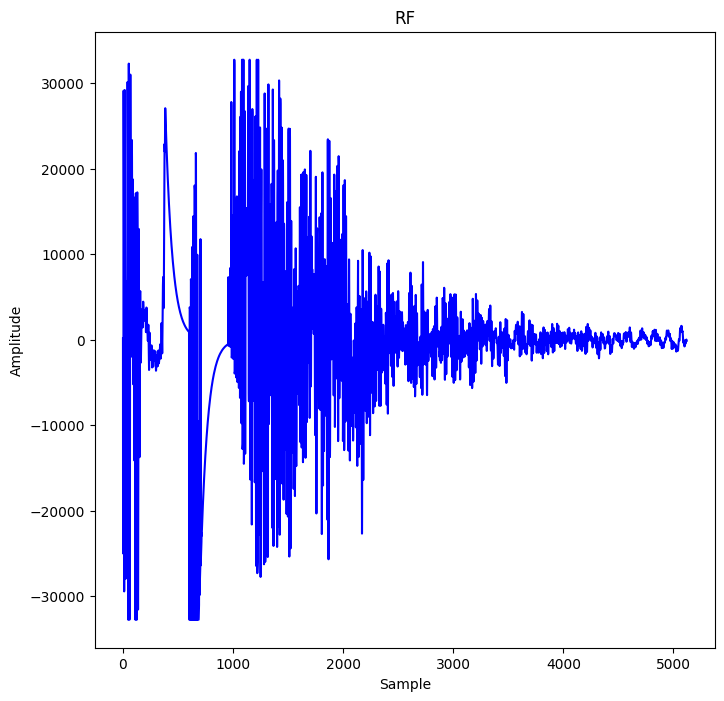

In [4]:
rfline = np.squeeze(rf[0, 50, :, 64])

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

axs.plot(rfline, 'blue')
axs.set_title('RF')
axs.set_ylabel('Amplitude')
axs.set_xlabel('Sample')

## Design FIR filters
In this example a custom set of FIR filter coefficients is used at the stage of RF filtering. Coeffricients are found using signal.remez function from SciPy package. Similarly, the FIR filter coefficients are found for filtering of demodulated signals of I/Q demodulation. Note: filter response is not fully validated.

In [5]:
## Design a band-pass FIR filter for RF filtering of raw channel data
band = rf_filter_band                # Desired pass band, Hz
trans_width = rf_filter_trans_width  # Width of transition from pass band to stop band, Hz
numtaps = rf_filter_numtaps          # Size of the FIR filter.

edges = [0, band[0] - trans_width, band[0], band[1], band[1] + trans_width, 0.5*fs]
rf_fir_taps = signal.remez(numtaps, edges, [0, 1, 0], Hz=fs)

## Design a low-pass FIR filter for filtering of down-conversion products
# Specify the filter parameters    
cutoff = demod_filter_cutoff            # Desired cutoff frequency, Hz
trans_width = demod_filter_trans_width  # Width of transition from pass band to stop band, Hz
numtaps = demod_filter_numtaps          # Size of the FIR filter.
iq_fir_taps = signal.remez(numtaps, [0, cutoff, cutoff + trans_width, 0.5*fs], [1, 0], Hz=fs)
    

C:\Users\us4us\AppData\Local\Temp\ipykernel_10628\1432058579.py:7: DeprecationWarning: 'remez' keyword argument 'Hz' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  rf_fir_taps = signal.remez(numtaps, edges, [0, 1, 0], Hz=fs)
C:\Users\us4us\AppData\Local\Temp\ipykernel_10628\1432058579.py:14: DeprecationWarning: 'remez' keyword argument 'Hz' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  iq_fir_taps = signal.remez(numtaps, [0, cutoff, cutoff + trans_width, 0.5*fs], [1, 0], Hz=fs)


## Define the processing pipeline and run the processing
In this part a set of procedures are put in the pipeline. Most of the procedures are taken from Arrus package. Three last procedures are taken from custom library developed specifically for SWE methods (SWE_utils_cupy_pipelined2.py) You can check how the procedures are written in this file to design your own methods. All procedures use GPU to speed-up the processing. Some functions use optimizaed CUDA kernels, while other are written using CuPy library, which is simple yet effective way of developing new methods with GPU processing.

The order of events is as follows:
1. Define the processing pipeline.
2. Transfer data to GPU memory.
3. Prepare the pipeline for execution (memory allocations, initializations, early validation)
4. Run the processing.
5. Get the data from the GPU memory back to PC.

In [6]:
## Define the processing pipeline and run processing
processing = Pipeline(
    steps=(
        Transpose(axes=(0, 1, 3, 2)),
        SelectFrames(np.arange(1, nFrames)),  # First frame is removed (reverberation effect)
        FirFilter(taps=rf_fir_taps, num_pkg=None, filter_pkg=None),
        QuadratureDemodulation(),
        Decimation(filter_type="fir", filter_coeffs=iq_fir_taps, decimation_factor=1),
        ReconstructLri(x_grid=x_grid, z_grid=z_grid, rx_tang_limits=rx_tang_limits),  # Beamforming
        Squeeze(),
        Output(),  # Output node for beamformed data
        AngleCompounding(nAngles=len(pwi_txAngles)), # CPWC if multiple plane waves are used 
        ShearwaveDetection(mode=swd_mode, packet_size=swd_ensemble_length, z_gate=swd_zGate_length, fc=pwi_txFreq), # Kasai's method
        Output(), # Output node for shear wave motion data
        ShearwaveMotionDataFiltering(sws_range=df_sws_range, f_range=df_f_range, k_range=df_k_range),
        # (Output node for last operation in the pipeline is created automatically)
    ),
    placement="/GPU:0"
)

# Prepare pipeline
print(f"Metadata shape: {metadata.input_shape}")
processing.prepare(metadata)

# Transfer data to GPU
din = cp.asarray(rf)

# Perform data processing
result = processing.process(din)

# Obtain data from individual steps of processing
# Nodes are indexed from the bottom of the pipeline
swdf          = result[0].get()  # Shear wave motion data after directional filtering in k-omega space) 
swd           = result[1].get()  # Shear wave motion data
bmf           = result[2].get()  # Beamformed data (not images, for images you need to detect envelope and compress the data)

# Check the sizes of arrays
print(swdf.shape)
print(swd.shape)
print(bmf.shape)

Metadata shape: (1, 80, 5120, 192)
SWD input data shape:
(79, 250, 250)
SWD input data shape:
(79, 250, 250)
(2, 249, 250, 78)
(249, 250, 78)
(79, 250, 250)


## Visualize the results of processing

#### Data after beamforming
To verify the beamforming process, the B-mode images are obtained below. To do this, the envelope is detected out of I/Q data and the log compression is performed.

Text(0.5, 1.0, 'Bmode [dB]')

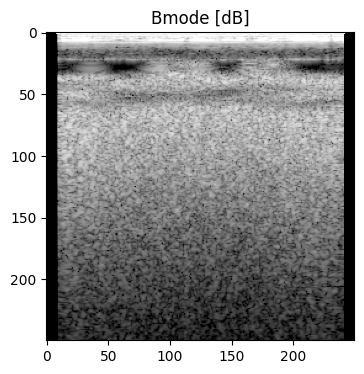

In [7]:
# Select the frame to draw
frame = 10

# Extract the frame from the data
bmf_frame = bmf[frame, :, :]

# Envelope detection
data = np.abs(bmf_frame)

# Log compression
data[data==0] = 10**-10
data = 20 * np.log10(data)

data_dim = data.shape
if(data_dim[1] >= data_dim[0] ):
    data = np.transpose(data, [1,0])

# Visualize the image
dB_range = [20, 84] 
norm = plt.Normalize(dB_range[0], dB_range[1], True)
fig, ax0 = plt.subplots(1, 1, figsize=(8, 4))

ax0.imshow(data, cmap='gray', norm=norm)
ax0.set_title('Bmode [dB]')

#### Shear wave motion data

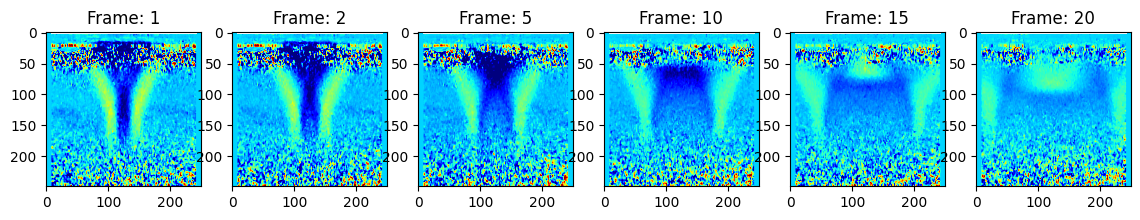

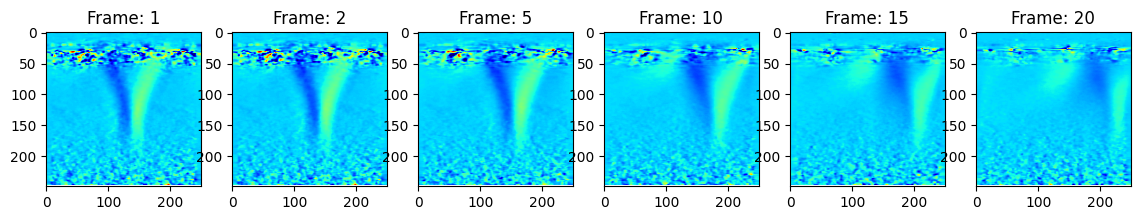

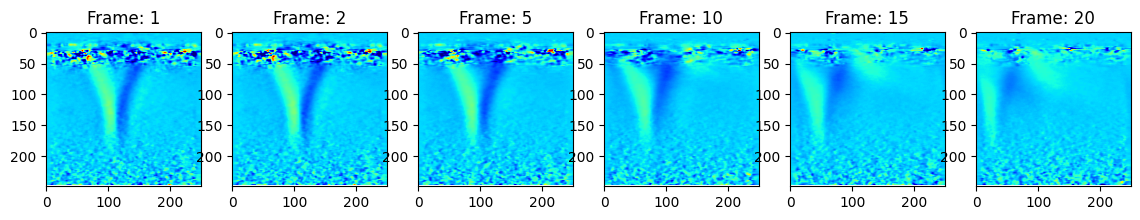

In [8]:
# Print SWD and SWDF data
Vrange = [-2e-3, 4e-3]
Vrange2 = [-0.25e-3, 0.5e-3]
DrawShearWaveFrames(data=swd,       Vrange=Vrange, frames=[1, 2, 5, 10, 15, 20])
DrawShearWaveFrames(data=swdf[0],   Vrange=Vrange, frames=[1, 2, 5, 10, 15, 20])
DrawShearWaveFrames(data=swdf[1],   Vrange=Vrange, frames=[1, 2, 5, 10, 15, 20])